In [79]:
import os
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

# 1 Código Deepview

## Filters

In [60]:
## Preprocess

# Gray 
def to_gray(frame, options=None):
    if frame is None:
      return None
      
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)    
    return gray

gray_filter = {
  "name": "to_gray",
  "filter": to_gray,
  "options": None,
}


# Skip dark
def skip_dark(frame, options=None):
  if frame is None:
      return None

  # Occupy 24,88% if the image
  rectangles = [
  ((157, 200), (587, 440)),
  ((744, 420), (1174, 660)),
  ((1331, 200), (1761, 440)),
  ((157, 640), (587, 880)),
  ((1331, 640), (1761, 880))
  ]

  mean_areas = []
  for left_top, right_bottom in rectangles:
    mean_areas.extend(frame[left_top[0]:right_bottom[0]][left_top[1]:right_bottom[1]])

  min_brightness = options.get("min_brightness")
  if min_brightness is None:
    min_brightness = 1


  # Calculate brightness
  brightness = np.mean(mean_areas)
  return frame

skip_dark_filter = {
  "name": "skip_dark",
  "filter": skip_dark,
  "options": {"min_brightness": 1}
}


# Top hat
def top_hat(frame, options):
    """Performs a top-hat operation on the given frame and returns the result."""
    # Getting the kernel to be used in Top-Hat

    if frame is None:
      return None
      
    filterSize = options["filterSize"]
    se = options["se"]

    kernel = cv.getStructuringElement(se,
                                      filterSize)

    # Applying the Top-Hat operation
    filtered_frame = cv.morphologyEx(frame,
                                     cv.MORPH_TOPHAT,
                                     kernel)

    return filtered_frame

top_hat_filter = {
    "name": "top_hat",
    "filter": top_hat,
    "options": {"filterSize": (9, 9), "se": cv.MORPH_ELLIPSE},
}


# Denoise
def denoise(frame, options=None):
  if frame is None:
      return None
  
  return frame

denoise_filter = {
  "name": "denoise",
  "filter": denoise,
  "options": None,
}



## Process

# Threshold
def threshold(frame, options):
  thresh = options['thresh']
  maxValue = options['maxValue']
  
  thresh_frame = cv.threshold(frame, thresh, maxValue, cv.THRESH_BINARY)[1]
  return thresh_frame

threshold_filter = {
  "name": "threshold",
  "filter": threshold,
  "options": {
    "thresh": 20,
    "maxValue": 255,
  }
}


# Dilate
def dilate(frame, options):
  iterations = options['iterations']
  kernelSize = options['kernelSize']
  
  # Definir el kernel para la dilatación
  kernel = np.ones(kernelSize, np.uint8)

  # Aplicar la dilatación a la imagen binaria
  dilated_frame = cv.dilate(frame, kernel, iterations=iterations)
  
  return dilated_frame

dilate_filter = {
  "name": "dilate",
  "filter": dilate,

  "options": {
    "kernelSize": (3, 3),
    "iterations": 1,
  }
}


In [61]:
# Filtros a aplicar sobre cada frame
preprocess = [
    # Pasar a escala de grises
    gray_filter,

    # Se ignoran los frames oscuros
    skip_dark_filter,

    # Homogeneizar fondo
    top_hat_filter,

    # Quitar ruido
    denoise_filter,  # Actualmente no hace nada  
]


process = [
    # Binarizar
    threshold_filter,  
]

In [62]:
def execute_filters(frame, filters, options):
    preprocessed = frame
    for meta in filters:
        filter = meta["filter"]
        
        # Add default options
        default_options = meta["options"] 
        filter_options = {}

        if (default_options is not None):
          filter_options.update(default_options)
        
        specific_options = options.get(meta["name"])

        if specific_options is not None:                                
            # Merge default and specific options
            filter_options.update(specific_options) 
                                                 
        preprocessed = filter(preprocessed, filter_options)

    return preprocessed



# 2 Helpers

In [63]:
def show_img(frame):
  try:
    cv.imshow('frame', frame)
    cv.waitKey(0)
  except Exception as e:
    print(e)
  finally:
    cv.destroyAllWindows()

In [64]:
def read_frames_in_folder(folder, pattern=None):
  frames = []
  for file in os.listdir(folder):
      if pattern and re.match(pattern, file):
        frame = cv.imread(os.path.join(folder, file))          
        frames.append({
            "file": file,
            "frame": frame,                         
        })

  return frames

In [65]:
def plot_image_histogram(frame, **kwargs):
    
    # # Calcular el histograma de intensidades
    # hist = cv.calcHist([frame], [0], None, [256], [0, 256])

    # # Crear una figura utilizando Plotly Express
    # fig = px.bar(x=list(range(256)), y=hist.flatten(), labels={'x': 'Intensidad', 'y': 'Frecuencia'},
    #              title='Histograma de la imagen',
    #              **kwargs)

    # # Mostrar el histograma
    # fig.show()


    # Con matplotlib

    plt.hist(frame.ravel(), 256, [0, 256])

    # Escala logarítmica
    plt.yscale('log')
    plt.show()
    

# 3 Selección del umbral

## 3.1 Otsu

In [66]:
def otsu_threshold(frame, options={}):
  try:
    ret, thresh = cv.threshold(frame, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)    
    return ret, thresh
  except Exception as e:
    print(e)
    return None

otsu_filter = {
  "name": "otsu",
  "filter": otsu_threshold,
  "options": {},
}

In [67]:
frame = cv.imread('.\\videos\\TunicadoC0013-26-11-2019-TF\\frame_1050.jpg')

output_folder = '.\\videos\\TunicadoC0013-26-11-2019-TF\\frame_1050'
os.makedirs(output_folder, exist_ok=True)

gray = to_gray(frame, gray_filter["options"])
cv.imwrite(os.path.join(output_folder, 'gray.jpg'), gray)

tophat = top_hat(gray, top_hat_filter["options"])
cv.imwrite(os.path.join(output_folder, 'tophat.jpg'), tophat)

thresh = threshold(tophat, threshold_filter["options"])
cv.imwrite(os.path.join(output_folder, 'thresh.jpg'), thresh)

used_otsu_threshold, otsu = otsu_threshold(tophat, otsu_filter["options"])
cv.imwrite(os.path.join(output_folder, 'otsu.jpg'), otsu)

True

In [68]:
# Detecciones usando binarizado normal
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print("Binarizado normal: ", len(contours))

# Detecciones usando binarizado otsu
contours, hierarchy = cv.findContours(otsu, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print("Binarizado otsu: ", len(contours))

Binarizado normal:  34
Binarizado otsu:  23119


In [69]:
def otsu_vs_binary(
  frames
):
  for i, frame in enumerate(frames):
    gray = to_gray(frame, gray_filter["options"])
    tophat = top_hat(gray, top_hat_filter["options"])
    thresh = threshold(tophat, threshold_filter["options"])
    used_otsu_threshold, otsu = used_otsu_threshold(tophat, otsu_filter["options"])

    print(f"Frame {i}")
    # Detecciones usando binarizado normal
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    print("Binarizado normal: ", len(contours))

    # Detecciones usando binarizado otsu
    contours, hierarchy = cv.findContours(otsu, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    print("Binarizado otsu: ", len(contours))

In [70]:
folder = ".\\videos\\TunicadoC0013-26-11-2019-TF"
frames = read_frames_in_folder(
  folder=folder,
  pattern=re.compile(r"frame_\d+\.jpg")
)

frames = sorted(frames, key=lambda x: int(x["file"].split("_")[1].split(".")[0]))

In [71]:
df = pd.DataFrame(columns=["filename", "binary", "otsu", "otsu_threshold"])

for i, frame in enumerate(frames):
  gray = to_gray(frame["frame"], gray_filter["options"])
  tophat = top_hat(gray, top_hat_filter["options"])
  thresh = threshold(tophat, {
    "thresh": 20,
    "maxValue": 255,
  })

  used_otsu_treshold, otsu = otsu_threshold(tophat, otsu_filter["options"])

  # Detecciones usando binarizado normal
  contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  binary_detections = len(contours)

  # Detecciones usando binarizado otsu
  contours, hierarchy = cv.findContours(otsu, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  otsu_detections = len(contours)

  df.loc[i] = [frame["file"], binary_detections, otsu_detections, used_otsu_treshold]

  frames[i] = {
    "gray": gray,
    "tophat": tophat,
    "thresh": thresh,
    "otsu": otsu,
    "file": frame["file"],
    "frame": frame["frame"],
  }

In [72]:
def get_frame(filename):
  found_frames = [f for f in frames if f["file"] == filename]
  if len(found_frames) > 0:
    return found_frames[0]
  else:
    return None

En la mayoría de frames seleccionados Otsu arroja un umbral de 0, por lo que los resultados nos son útiles. Sospecho que es debido a que los objetos son tan pequeños que no generan un pico en el histograma de la imagen (no es bimodal) 

In [73]:
df[[
  "filename",
  "binary",
  "otsu",
  "otsu_threshold",
]]

,filename,binary,otsu,otsu_threshold
0,frame_150.jpg,8,22886,0.0
1,frame_300.jpg,20,22963,0.0
2,frame_450.jpg,24,22846,0.0
3,frame_600.jpg,11,23018,0.0
4,frame_750.jpg,6,23131,0.0
5,frame_900.jpg,16,19507,0.0
6,frame_1050.jpg,34,23119,0.0
7,frame_1200.jpg,34,22694,0.0
8,frame_1350.jpg,32,28,26.0
9,frame_1500.jpg,15,23007,0.0


A excepción de dos casos en los que el umbral parece ser más razonable: frame 1350 y frame 1800. Comparemos los histogramas del frame 1350 con los de, por ejemplo, la imagen 900

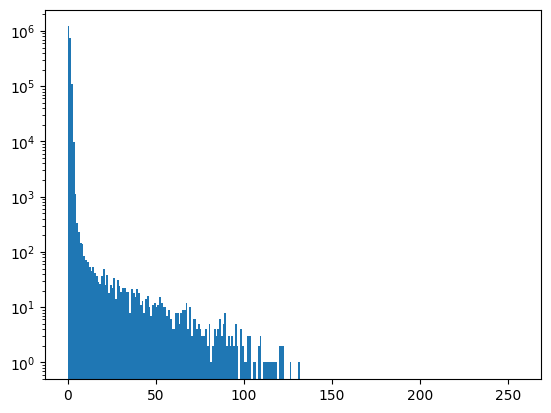

In [74]:
plot_image_histogram(
  get_frame("frame_1350.jpg")["tophat"],
  # Escala logarítmica
  log_y=True,
)

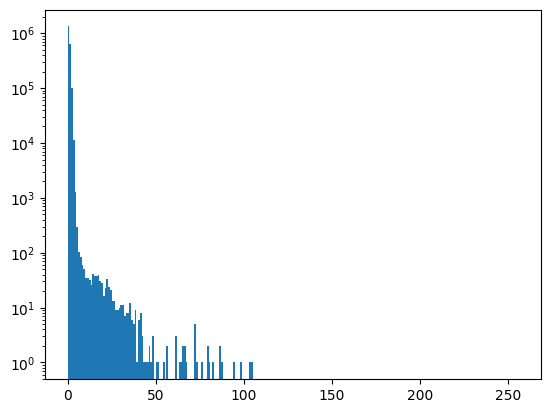

In [75]:
plot_image_histogram(
  get_frame("frame_900.jpg")["tophat"],
  # Escala logarítmica
  log_y=True,
)

In [76]:
show_img(get_frame("frame_1050.jpg")["otsu"])

## 3.2 Detecciones vs Umbral

In [77]:
selected_frames = [
  "frame_1050.jpg"
]

def get_threshold_range():
  return range(3, 50)

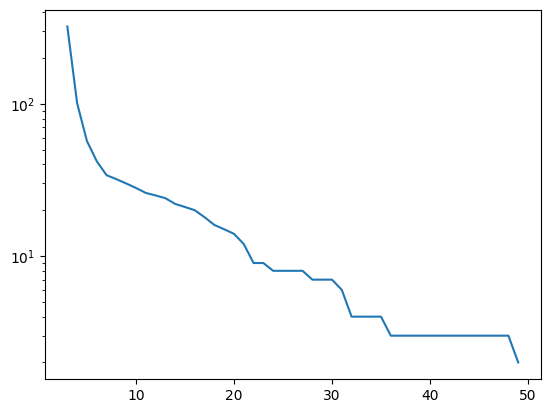

In [86]:
frame = get_frame("frame_1650.jpg")

treshold_df = pd.DataFrame(columns=["threshold", "detections"])

for threshold_value in get_threshold_range():
    retophat = top_hat(frame["tophat"], top_hat_filter["options"])

    thresh = threshold(retophat, {
        "thresh": threshold_value,
        "maxValue": 255,
    })

    dilated_thresh = dilate(thresh, {
        'kernelSize': (3, 3),
        'iterations': 1})

    contours, hierarchy = cv.findContours(
        dilated_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    detections = len(contours)

    treshold_df.loc[threshold_value] = [threshold_value, detections]

# px.line(
#     treshold_df,
#     x="threshold",
#     y="detections",
#     title="Detecciones por umbral",
#     log_y=True,
#     width=600
# )

# Line con matplotlib, escala logarítmica

plt.plot(treshold_df["threshold"], treshold_df["detections"])
plt.yscale("log")


No aparece de forma clara una forma de "silla" clara 